<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/PNEUMONIA_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👉👉👉***Pneumonia Classification on TPU***👈👈👈

In [ ]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.64.80.162:8470
Number of replicas: 8


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [ ]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [ ]:
count_normal = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
count_normal

Exception ignored in: <function Executor.__del__ at 0x7d4b8e51db40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


1349

In [ ]:
count_pneumonia = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
count_pneumonia

Exception ignored in: <function Executor.__del__ at 0x7d4b8e51db40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


3883

In [ ]:
def get_label(filepath):
  split = tf.strings.split(filepath, "/")
  return split[-2] == "PNEUMONIA"

In [ ]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels = 3)
  return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
def process_path(img, label):
  label = get_label(label)
  img = decode_img(img)
  return img, label

In [ ]:
ds = ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [ ]:
data = ds.shuffle(10000)
train_data = data.take(4200)
val_data = data.skip(4200)

In [ ]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_data = tf.data.Dataset.zip((test_images, test_paths))

test_data = test_data.map(process_path, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE)

In [ ]:
def prepare_data(data, cache = True):
  if cache:
    if isinstance(cache, str):
      data = data.cache(cache)
    else :
      data = data.cache()
  data = data.batch(BATCH_SIZE)
  data = data.prefetch(buffer_size = AUTOTUNE)
  return data

In [ ]:
train_data = prepare_data(train_data)
val_data = prepare_data(val_data)

In [ ]:
img, label = next(iter(train_data))

In [ ]:
def display_img(img, label):
  plt.figure(figsize=(10,10))
  for n in range(25):
    plt.subplot(5,5,n+1)
    plt.imshow(img[n] / 255.0)
    if label[n]:
      plt.title("PNEUMONIA")
    else:
      plt.title("NORMAL")
    plt.axis("off")
  plt.show()

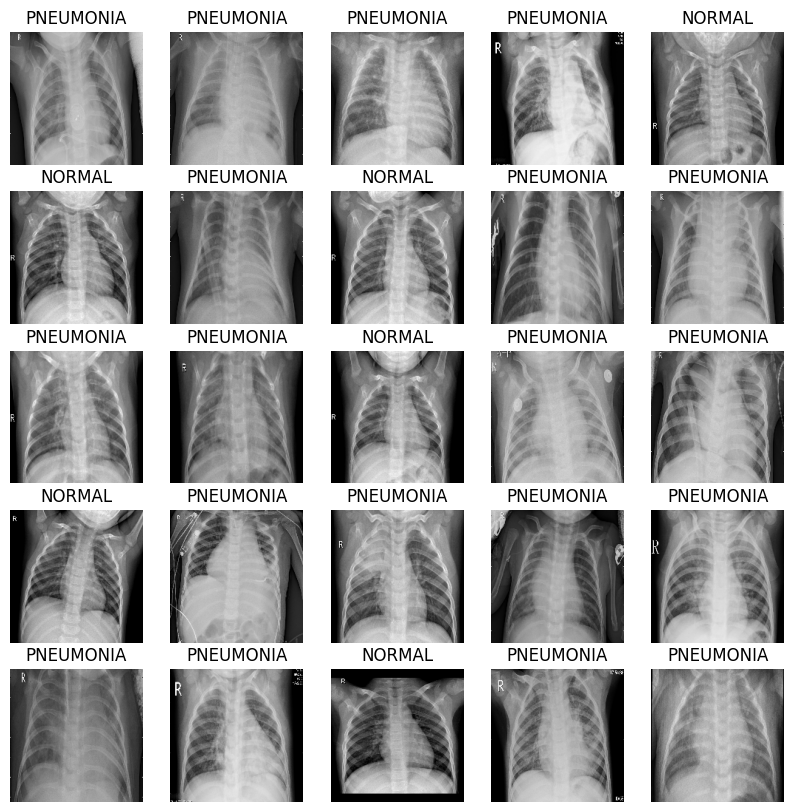

In [ ]:
display_img(img.numpy(), label.numpy())

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [ ]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
initial_bias = np.log([count_pneumonia / count_normal])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = count_normal + count_pneumonia
weight_for_0 = (1 / count_normal) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / count_pneumonia) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
callbacks = [checkpoint, early_stopping]

In [ ]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    class_weight=class_weight,
    callbacks= callbacks
)

Epoch 1/100
21/21 [==============================] - 32s 635ms/step - loss: 0.6317 - binary_accuracy: 0.6669 - precision: 0.8792 - recall: 0.6382 - val_loss: 0.5646 - val_binary_accuracy: 0.7674 - val_precision: 0.7674 - val_recall: 1.0000
Epoch 2/100
21/21 [==============================] - 4s 176ms/step - loss: 0.2969 - binary_accuracy: 0.8705 - precision: 0.9639 - recall: 0.8573 - val_loss: 1.0012 - val_binary_accuracy: 0.7674 - val_precision: 0.7674 - val_recall: 1.0000
Epoch 3/100
21/21 [==============================] - 4s 194ms/step - loss: 0.1755 - binary_accuracy: 0.9300 - precision: 0.9776 - recall: 0.9267 - val_loss: 0.6491 - val_binary_accuracy: 0.7258 - val_precision: 1.0000 - val_recall: 0.6427
Epoch 4/100
21/21 [==============================] - 4s 173ms/step - loss: 0.1630 - binary_accuracy: 0.9350 - precision: 0.9807 - recall: 0.9306 - val_loss: 0.6955 - val_binary_accuracy: 0.7849 - val_precision: 0.7811 - val_recall: 1.0000
Epoch 5/100
21/21 [========================

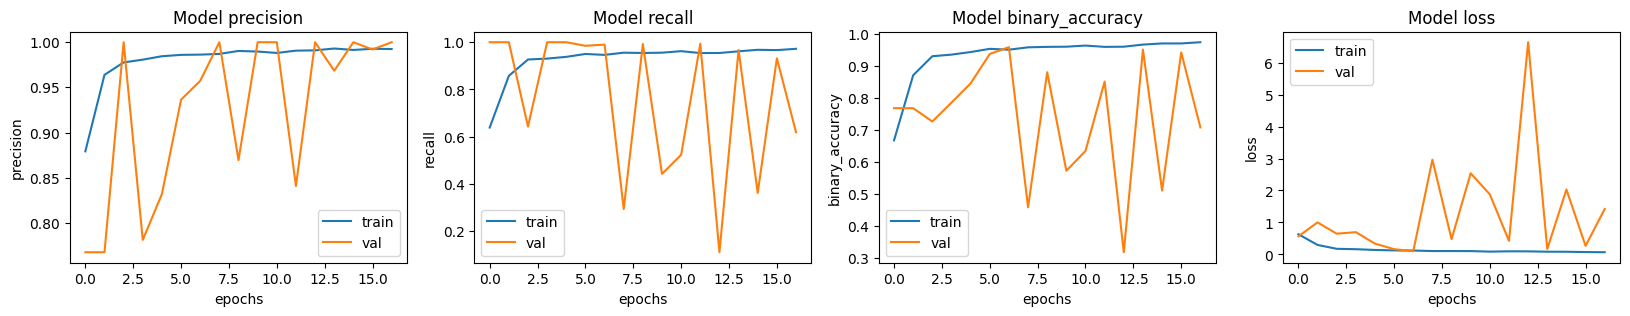

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
model.evaluate(test_data, return_dict=True)

4/4 [==============================] - 6s 1s/step - loss: 0.7954 - binary_accuracy: 0.7532 - precision: 0.7169 - recall: 1.0000


{'loss': 0.7953652739524841,
 'binary_accuracy': 0.7532051205635071,
 'precision': 0.716911792755127,
 'recall': 1.0}

<ipython-input-25-57016f3fc8a7>:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.title(CLASS_NAMES[label[0].numpy()])
Exception ignored in: <function Executor.__del__ at 0x7d4b8e51db40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


1/1 [==============================] - 6s 6s/step
This image is 62.72 percent NORMAL
This image is 37.28 percent PNEUMONIA


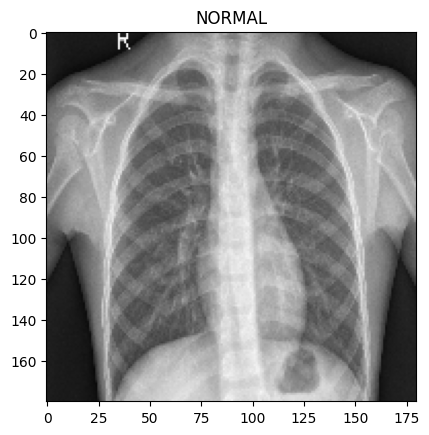

In [ ]:
for image, label in test_data.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_data.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))